In [230]:

import requests
from fake_useragent import UserAgent

ua = UserAgent()

URL_IMDB = "https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2018-12-31"
headers = {
    "User-Agent": f"{ua.random}",
}
response = requests.get(URL_IMDB, headers=headers)

In [231]:
from bs4 import BeautifulSoup
import pandas as pd

soup = BeautifulSoup(response.text, "html.parser")
list_film_elem = soup.find("ul", class_="ipc-metadata-list--base")
list_film = list_film_elem.find_all("li", recursive=False)
len(list_film)

50

In [1]:
import re


def extract_id(link):
    regex = r"\/title\/tt(\d+)\/"
    match = re.search(regex, link)
    if match:
        return match.group(1)
    else:
        return None


In [233]:
import time
from tqdm.notebook import tqdm

extract_id(list_film[0].find("a", class_="ipc-title-link-wrapper").get("href"))
film_dict = []
for film in tqdm(list_film, total=len(list_film), desc="Films", unit="film", leave=True):
    time.sleep(1)
    response_film = requests.get(f"https://www.imdb.com{film.find('a', class_='ipc-title-link-wrapper').get('href')}",
                                 headers=headers)
    if response_film.status_code != 200:
        break
    soup_film = BeautifulSoup(response_film.text, "html.parser")
    _id = title = duration = gender_list = release_date = user_rating = nb_user_rating = None
    _id = extract_id(film.find("a", class_="ipc-title-link-wrapper").get("href"))
    if h1_title := soup_film.find("h1", {"data-testid": "hero__pageTitle"}):
        title = h1_title.find("span").get_text(strip=True)
    if li_duration := soup_film.find("li", {"data-testid": "title-techspec_runtime"}):
        duration = li_duration.find("div", class_="ipc-metadata-list-item__content-container").get_text(strip=True)
    if li_gender_list := soup_film.find("li", {"data-testid": "storyline-genres"}):
        if ul_gender_list := li_gender_list.find("ul",
                                                 class_="ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content base"):
            gender_list = []
            for li_gender in ul_gender_list.find_all('li', recursive=False):
                gender_list.append(li_gender.find("a").get_text(strip=True))
    if li_release_date := soup_film.find("li", {"data-testid": "title-details-releasedate"}):
        if a_release_date := li_release_date.find("a", class_="ipc-metadata-list-item__list-content-item"):
            release_date = a_release_date.get_text(strip=True)
    if div_user_rating := soup_film.find("div", {"data-testid": "hero-rating-bar__aggregate-rating__score"}):
        user_rating = div_user_rating.find("span").get_text()
        nb_user_rating = div_user_rating.parent.find_all('div')[-1].get_text()
    film_dict.append({
        "id": _id,
        "title": title,
        "duration": duration,
        "gender_list": gender_list,
        "release_date": release_date,
        "user_rating": user_rating,
        "nb_user_rating": nb_user_rating
    })

df = pd.DataFrame(film_dict)
df.to_csv("../data/imdb.csv", index=False)
df.head()

Films:   0%|          | 0/50 [00:00<?, ?film/s]

,id,title,duration,gender_list,release_date,user_rating,nb_user_rating
0,4633694,Spider-Man: Into the Spider-Verse,1hour57minutes,None,"December 14, 2018 (Canada)",8.4,641K
1,7784604,Hereditary,2hours7minutes,None,"June 8, 2018 (Canada)",7.3,362K
2,5814060,The Nun,1hour36minutes,None,"September 7, 2018 (Canada)",5.3,165K
3,2709692,Dr. Seuss' the Grinch,1hour25minutes,None,"November 9, 2018 (Canada)",6.4,81K
4,4154756,Avengers: Infinity War,2hours29minutes,None,"April 27, 2018 (Canada)",8.4,1.2M


## 2. 2 Exploitation des donn´ees
### 2.1 Nettoyer et coder vos donn´ees : correction d’erreurs, traitement de valeurs manquantes s’il y a lieu, ´eliminations des duplications, ´eliminations des lignes avec des valeurs ab´erantes, et correction du type des donn´ees (codage si c’est n´ecessaire).

In [157]:
import pandas as pd

df = pd.read_csv("../data/movie_data.csv")
df.head()

,index,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,date_ext
0,0,Black Panther,7.3,Action Adventure Sci-Fi,134.0,tt1825683,758827,(2018),"February 16, 2018"
1,1,Hereditary,7.3,Drama Horror Mystery,127.0,tt7784604,314486,(2018),"June 8, 2018"
2,2,Mile 22,6.1,Action Thriller,94.0,tt4560436,80168,(2018),"August 17, 2018"
3,3,Avengers: Infinity War,8.4,Action Adventure Sci-Fi,149.0,tt4154756,1069513,(2018),"April 27, 2018"
4,4,Suspiria,6.7,Drama Fantasy Horror,152.0,tt1034415,78980,(I) (2018),"November 2, 2018"


In [158]:
df.drop(columns=['index'], inplace=True)
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,date_ext
0,Black Panther,7.3,Action Adventure Sci-Fi,134.0,tt1825683,758827,(2018),"February 16, 2018"
1,Hereditary,7.3,Drama Horror Mystery,127.0,tt7784604,314486,(2018),"June 8, 2018"
2,Mile 22,6.1,Action Thriller,94.0,tt4560436,80168,(2018),"August 17, 2018"
3,Avengers: Infinity War,8.4,Action Adventure Sci-Fi,149.0,tt4154756,1069513,(2018),"April 27, 2018"
4,Suspiria,6.7,Drama Fantasy Horror,152.0,tt1034415,78980,(I) (2018),"November 2, 2018"


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12909 entries, 0 to 12908
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   titre_film             12909 non-null  object 
 1   utilisateur_note       7642 non-null   float64
 2   genres_liste           12189 non-null  object 
 3   duree                  9772 non-null   float64
 4   id_film                12909 non-null  object 
 5   nbre_utilisateur_note  7645 non-null   object 
 6   date_sortie            12840 non-null  object 
 7   date_ext               12909 non-null  object 
dtypes: float64(2), object(6)
memory usage: 806.9+ KB


In [160]:
df.describe()

,utilisateur_note,duree
count,7642.000000,9772.000000
mean,5.859827,96.861543
std,1.435517,28.714294
min,1.000000,2.000000
25%,5.000000,83.000000
50%,6.000000,93.000000
75%,6.800000,109.000000
max,10.000000,808.000000


In [161]:
df.dtypes

titre_film                object
utilisateur_note         float64
genres_liste              object
duree                    float64
id_film                   object
nbre_utilisateur_note     object
date_sortie               object
date_ext                  object
dtype: object

In [162]:
df.isna().sum()

titre_film                  0
utilisateur_note         5267
genres_liste              720
duree                    3137
id_film                     0
nbre_utilisateur_note    5264
date_sortie                69
date_ext                    0
dtype: int64

In [163]:
df = df[~df['duree'].isna()]
df = df[df['duree'] != 0]
df.isna().sum()

titre_film                  0
utilisateur_note         2721
genres_liste              227
duree                       0
id_film                     0
nbre_utilisateur_note    2719
date_sortie                 9
date_ext                    0
dtype: int64

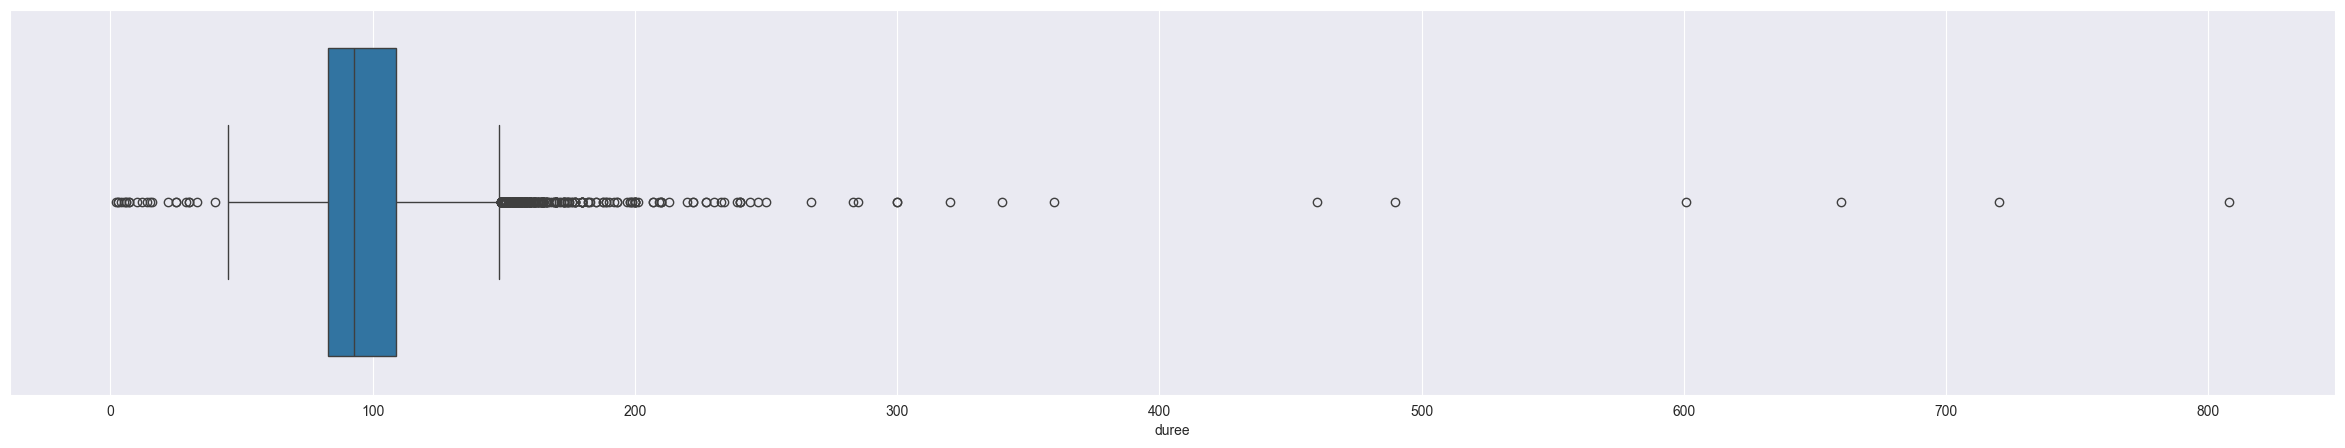

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
sns.boxplot(x=df['duree'])
plt.show()

In [165]:
def delete_high_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    higher_edge = q3 + 1.5 * iqr
    print(df[df[col] > higher_edge].shape[0], "high outliers")
    df = df[df[col] <= higher_edge]
    return df

In [166]:
df = delete_high_outliers(df, 'duree')

321 high outliers


In [167]:
df = df.astype({'duree': 'int64'})

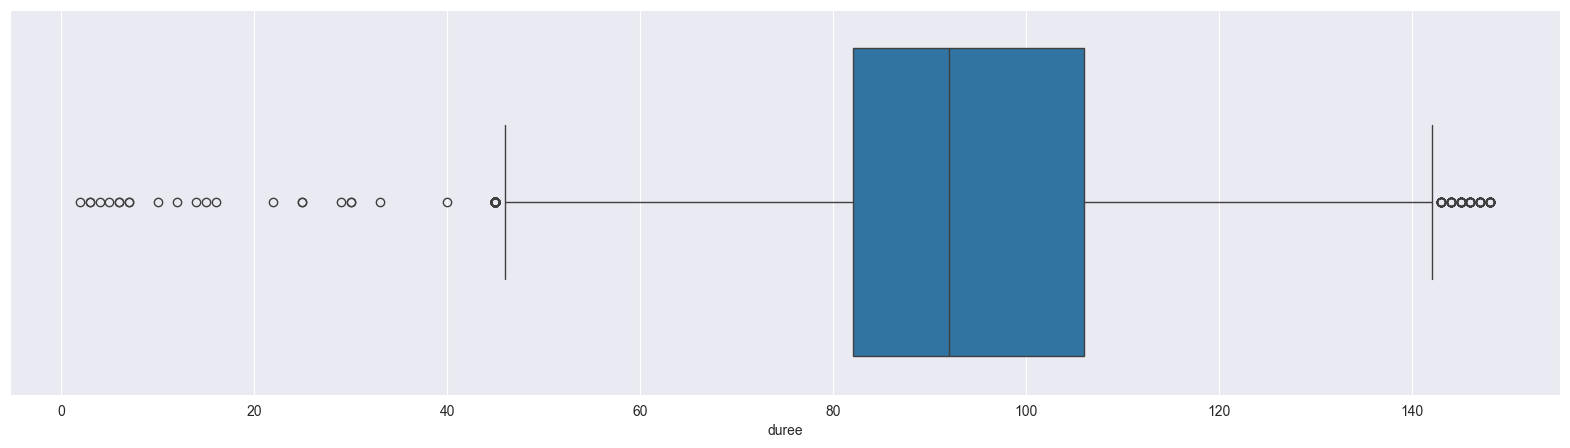

In [168]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['duree'])
plt.show()

In [169]:
import numpy as np


def convert_nb_user_rating(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, int):
        return value
    try:
        return int(value)
    except ValueError:
        return np.nan

In [170]:
df['nbre_utilisateur_note'] = df['nbre_utilisateur_note'].apply(convert_nb_user_rating)
df['nbre_utilisateur_note'].fillna(df['nbre_utilisateur_note'].median(), inplace=True)
df = df.astype({'nbre_utilisateur_note': 'int64'})
df = delete_high_outliers(df, 'nbre_utilisateur_note')
df.dtypes


1563 high outliers


titre_film                object
utilisateur_note         float64
genres_liste              object
duree                      int64
id_film                   object
nbre_utilisateur_note      int64
date_sortie               object
date_ext                  object
dtype: object

In [171]:
df = df[~df['titre_film'].duplicated()]

In [172]:
df.drop(columns=['date_sortie'], inplace=True)
df.rename(columns={'date_ext': 'date_sortie'}, inplace=True)
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie
102,Strangeways Here We Come,5.1,Comedy Crime,86,tt4299774,334,"October 5, 2018"
258,Virndavani Vairagya,6.6,Drama,91,tt9675282,25,"April 3, 2018"
259,Dirty Work,3.3,Drama Romance Thriller,73,tt7243754,380,"February 3, 2018"
280,Peripheral,4.8,Horror Sci-Fi,89,tt5658672,224,"August 3, 2020"
297,Mar,5.5,Drama,103,tt7490386,49,"May 16, 2019"


In [173]:
df['date_sortie'].isna().sum()

0

In [174]:
df = delete_high_outliers(df, 'nbre_utilisateur_note')

1012 high outliers


In [175]:
def split_genre(value):
    if pd.isna(value):
        return []
    return value.split('  ')


split_genre('Action  Adventure  Sci-Fi')

['Action', 'Adventure', 'Sci-Fi']

In [176]:
df['genres_liste'] = df['genres_liste'].apply(lambda x: split_genre(x))
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie
258,Virndavani Vairagya,6.6,[Drama],91,tt9675282,25,"April 3, 2018"
280,Peripheral,4.8,"[Horror, Sci-Fi]",89,tt5658672,224,"August 3, 2020"
297,Mar,5.5,[Drama],103,tt7490386,49,"May 16, 2019"
318,Exploitation,4.1,[Comedy],111,tt7543138,61,"April 24, 2018"
364,Can't Have You,3.7,"[Comedy, Drama, Romance]",90,tt7141148,145,"March 7, 2018"


In [177]:
df['genres_liste'].explode().value_counts()

genres_liste
Drama         3416
Comedy        1614
Thriller       719
Horror         677
Romance        623
Action         544
Crime          362
Family         338
Fantasy        298
Mystery        285
Adventure      281
Animation      204
Sci-Fi         180
Music          124
History        120
Musical         89
Sport           88
Biography       83
War             51
Western         33
Reality-TV      15
Talk-Show        8
News             6
Name: count, dtype: int64

In [178]:
top_6_genres = df['genres_liste'].explode().value_counts().head(6).index
for genre in top_6_genres:
    df[genre] = df['genres_liste'].apply(lambda x: 1 if genre in x else 0)


def other_genres(row):
    return 1 if any(genre not in top_6_genres for genre in row) else 0


df['autres_genres'] = df['genres_liste'].apply(other_genres)

df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,Drama,Comedy,Thriller,Horror,Romance,Action,autres_genres
258,Virndavani Vairagya,6.6,[Drama],91,tt9675282,25,"April 3, 2018",1,0,0,0,0,0,0
280,Peripheral,4.8,"[Horror, Sci-Fi]",89,tt5658672,224,"August 3, 2020",0,0,0,1,0,0,1
297,Mar,5.5,[Drama],103,tt7490386,49,"May 16, 2019",1,0,0,0,0,0,0
318,Exploitation,4.1,[Comedy],111,tt7543138,61,"April 24, 2018",0,1,0,0,0,0,0
364,Can't Have You,3.7,"[Comedy, Drama, Romance]",90,tt7141148,145,"March 7, 2018",1,1,0,0,1,0,0


In [179]:
df['date_sortie'] = pd.to_datetime(df['date_sortie'], format='%B %d, %Y', errors='coerce')
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,Drama,Comedy,Thriller,Horror,Romance,Action,autres_genres
258,Virndavani Vairagya,6.6,[Drama],91,tt9675282,25,2018-04-03,1,0,0,0,0,0,0
280,Peripheral,4.8,"[Horror, Sci-Fi]",89,tt5658672,224,2020-08-03,0,0,0,1,0,0,1
297,Mar,5.5,[Drama],103,tt7490386,49,2019-05-16,1,0,0,0,0,0,0
318,Exploitation,4.1,[Comedy],111,tt7543138,61,2018-04-24,0,1,0,0,0,0,0
364,Can't Have You,3.7,"[Comedy, Drama, Romance]",90,tt7141148,145,2018-03-07,1,1,0,0,1,0,0


titre_film                  0
utilisateur_note         2569
genres_liste                0
duree                       0
id_film                     0
nbre_utilisateur_note       0
date_sortie                 0
Drama                       0
Comedy                      0
Thriller                    0
Horror                      0
Romance                     0
Action                      0
autres_genres               0
dtype: int64
(6807, 14)


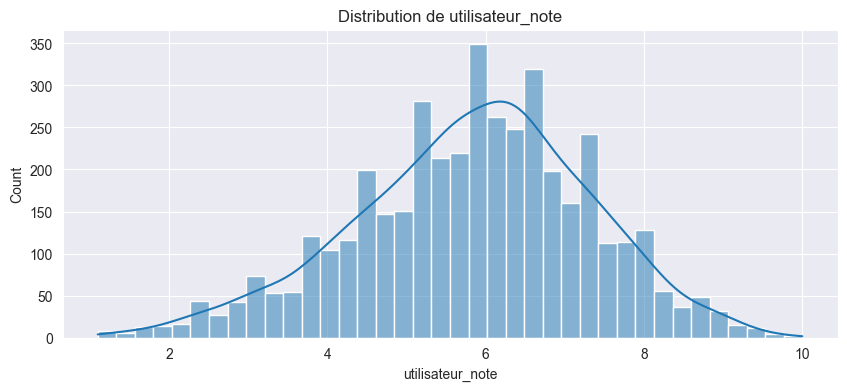

In [180]:
print(df.isna().sum())
print(df.shape)
# distribution of utilisateur_note
plt.figure(figsize=(10, 4))
sns.histplot(df['utilisateur_note'], kde=True)
plt.title('Distribution de utilisateur_note')
plt.show()


In [181]:
# df['utilisateur_note'].fillna(df['utilisateur_note'].median(), inplace=True)
df.dropna(subset=['utilisateur_note'], inplace=True)

### 2.2 Cr´eer 2 nouvelles colonnes dur´ee minutes log, nbre utilisateur note log.

• Appliquer la fonction logarithmique sur la colonne dur´ee pour avoir la nouvelle colonne dur´ee minutes log.

• Appliquer la fonction logarithmique sur la colonne nbre utilisateur note pour avoir la nouvelle colonne nbre utilisateur note log.

In [182]:
df['duree_log'] = np.log(df['duree'])
df['nbre_utilisateur_note_log'] = np.log(df['nbre_utilisateur_note'])
df

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,Drama,Comedy,Thriller,Horror,Romance,Action,autres_genres,duree_log,nbre_utilisateur_note_log
258,Virndavani Vairagya,6.6,[Drama],91,tt9675282,25,2018-04-03,1,0,0,0,0,0,0,4.510860,3.218876
280,Peripheral,4.8,"[Horror, Sci-Fi]",89,tt5658672,224,2020-08-03,0,0,0,1,0,0,1,4.488636,5.411646
297,Mar,5.5,[Drama],103,tt7490386,49,2019-05-16,1,0,0,0,0,0,0,4.634729,3.891820
318,Exploitation,4.1,[Comedy],111,tt7543138,61,2018-04-24,0,1,0,0,0,0,0,4.709530,4.110874
364,Can't Have You,3.7,"[Comedy, Drama, Romance]",90,tt7141148,145,2018-03-07,1,1,0,0,1,0,0,4.499810,4.976734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12641,Battlefield Enforcement,2.4,"[Action, Drama]",49,tt8208034,12,2018-08-15,1,0,0,0,0,1,0,3.891820,2.484907
12657,Roots of Good Men,4.9,[Drama],120,tt10886732,18,2018-10-22,1,0,0,0,0,0,0,4.787492,2.890372
12678,Couteau suisse,7.9,[],59,tt10594652,7,2020-02-12,0,0,0,0,0,0,0,4.077537,1.945910
12683,L'estate di Gino,7.7,[Biography],77,tt9390342,7,2018-12-06,0,0,0,0,0,0,1,4.343805,1.945910


### 2.3 R´ealiser une analyse univari´ee compl`ete avec les visualisations ad´equates et interpr´eter les r´esultats.

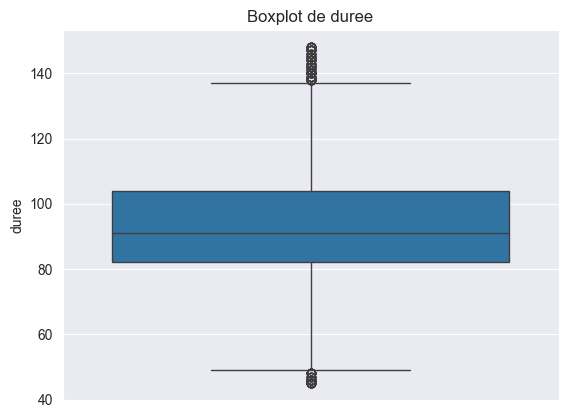

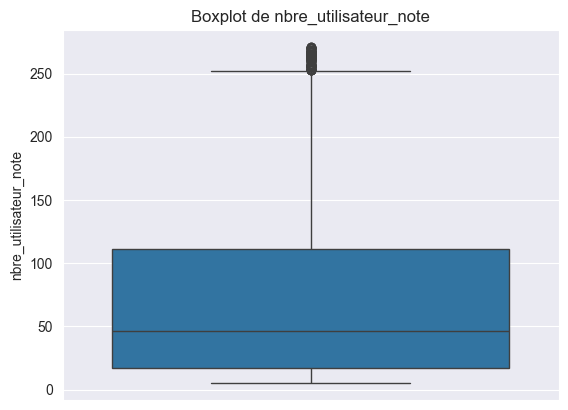

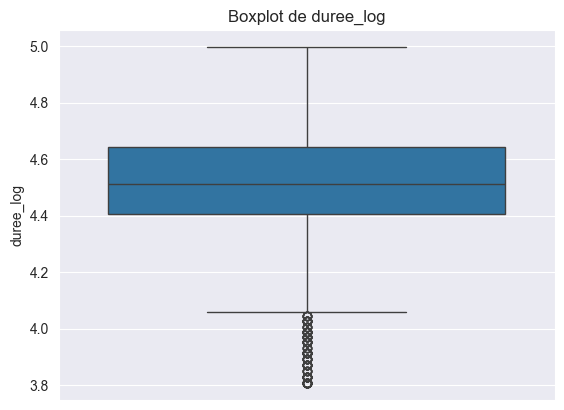

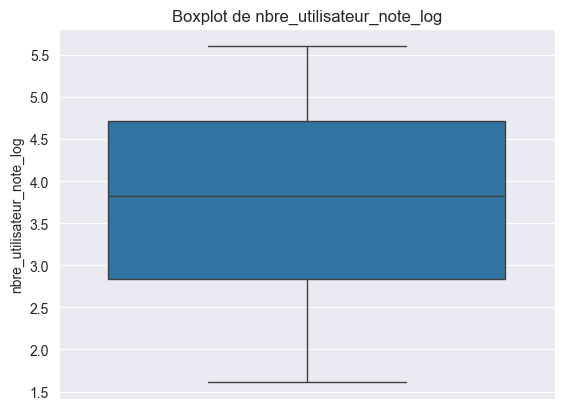

<Figure size 640x480 with 0 Axes>

In [183]:
for col in ['duree', 'nbre_utilisateur_note', 'duree_log', 'nbre_utilisateur_note_log']:
    sns.boxplot(data=df[col])
    plt.title(f'Boxplot de {col}')
    plt.figure()

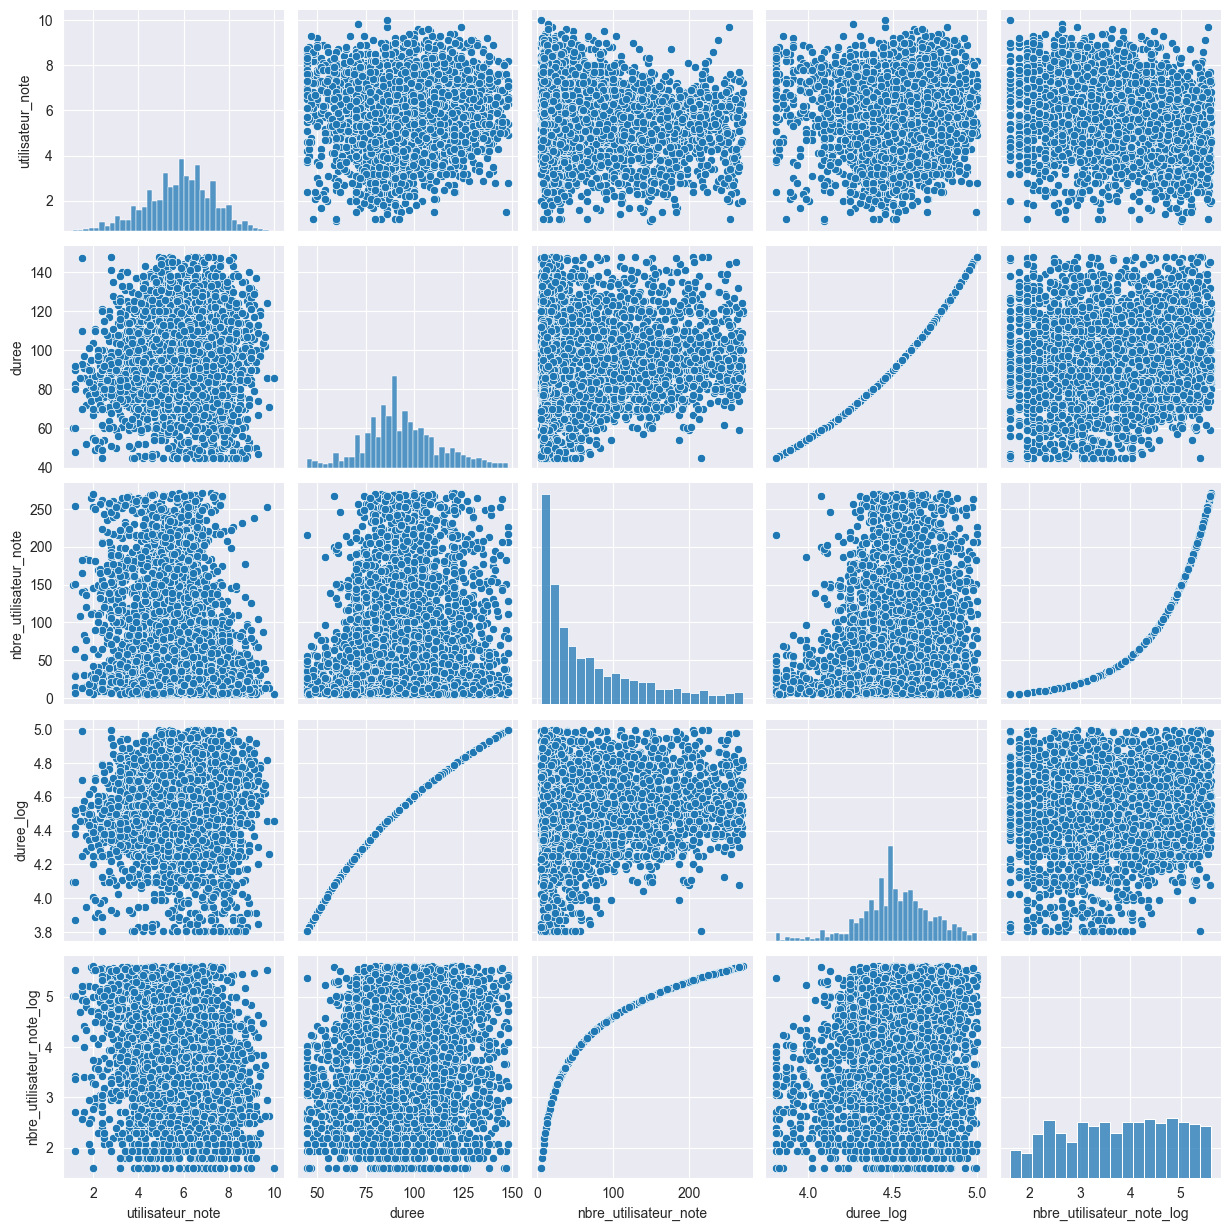

<Figure size 640x480 with 0 Axes>

In [184]:
sns.pairplot(df[['utilisateur_note', 'duree', 'nbre_utilisateur_note', 'duree_log', 'nbre_utilisateur_note_log']])
plt.show()
plt.savefig('../pairplot-part2.png')

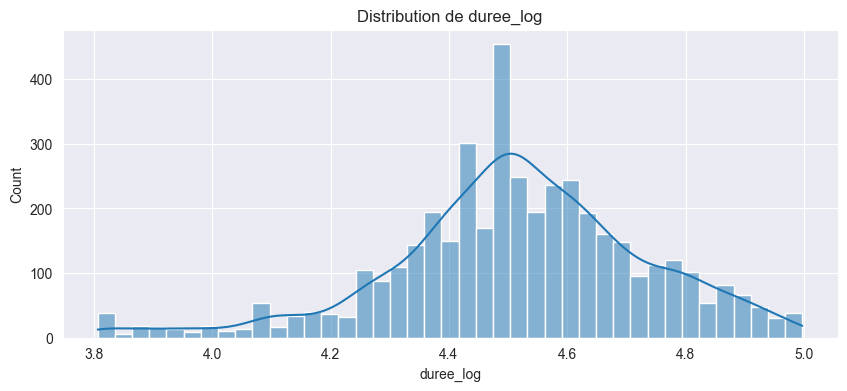

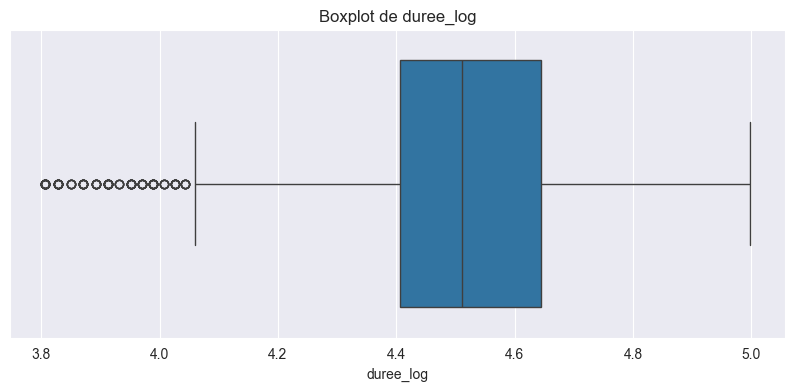

count    4238.000000
mean        4.515995
std         0.215740
min         3.806662
25%         4.406719
50%         4.510860
75%         4.644391
max         4.997212
Name: duree_log, dtype: float64


In [185]:
# Analyse d'une variable numérique
plt.figure(figsize=(10, 4))
sns.histplot(df['duree_log'], kde=True)
plt.title('Distribution de duree_log')
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['duree_log'])
plt.title('Boxplot de duree_log')
plt.show()

# Afficher les statistiques descriptives
print(df['duree_log'].describe())

### 2.4 R´ealiser une analyse bivari´ee compl`ete avec les visualisations ad´equates et interpr´eter les r´esultats.

<Axes: >

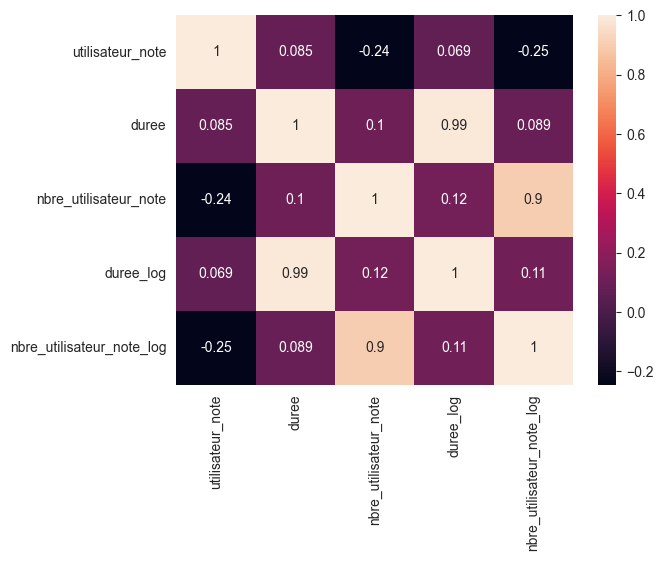

In [186]:
sns.heatmap(df[['utilisateur_note', 'duree', 'nbre_utilisateur_note', 'duree_log', 'nbre_utilisateur_note_log']].corr(),
            annot=True)

### 2.5 Dans cette question, on s’int´eresse a` pr´edire la note d’un film utilisateur note en fonction de 6 colonnes nbre utilisateur note log, dur´ee minutes log, drame, action, thriller, et horreur. Concevez un mod`ele de r´egression lin´eaire qui permet de faire cette pr´ediction, v´erifier les 4 conditions n´ecessaires pour appliquer la r´egression lin´eaire et ´evaluer votre mod`ele.

In [187]:
df.isna().sum()

titre_film                   0
utilisateur_note             0
genres_liste                 0
duree                        0
id_film                      0
nbre_utilisateur_note        0
date_sortie                  0
Drama                        0
Comedy                       0
Thriller                     0
Horror                       0
Romance                      0
Action                       0
autres_genres                0
duree_log                    0
nbre_utilisateur_note_log    0
dtype: int64

In [188]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df[['nbre_utilisateur_note_log', 'duree_log', 'Drama', 'Thriller', 'Horror', 'Action']]

y = df['utilisateur_note']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#R2
print('R2 :', r2_score(y_test, y_pred))

#MSE
print('MSE :', mean_squared_error(y_test, y_pred))

# r2adj
print('r2adj :', 1 - (1 - r2_score(y_test, y_pred)) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1)))

R2 : 0.171640144939877
MSE : 1.8296766456528166
r2adj : 0.16573032433302715


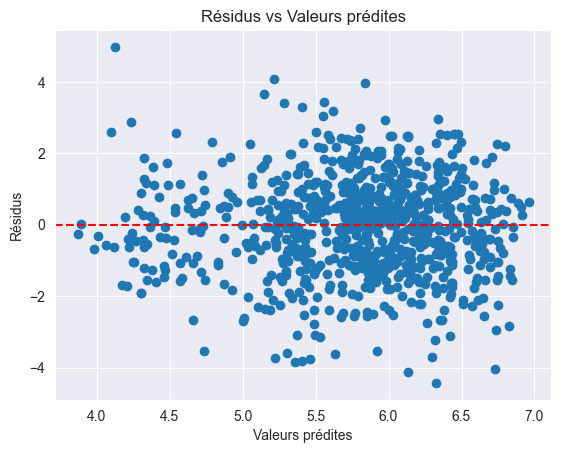

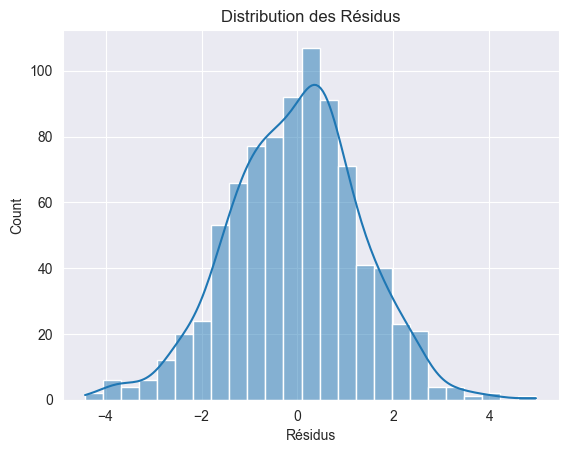

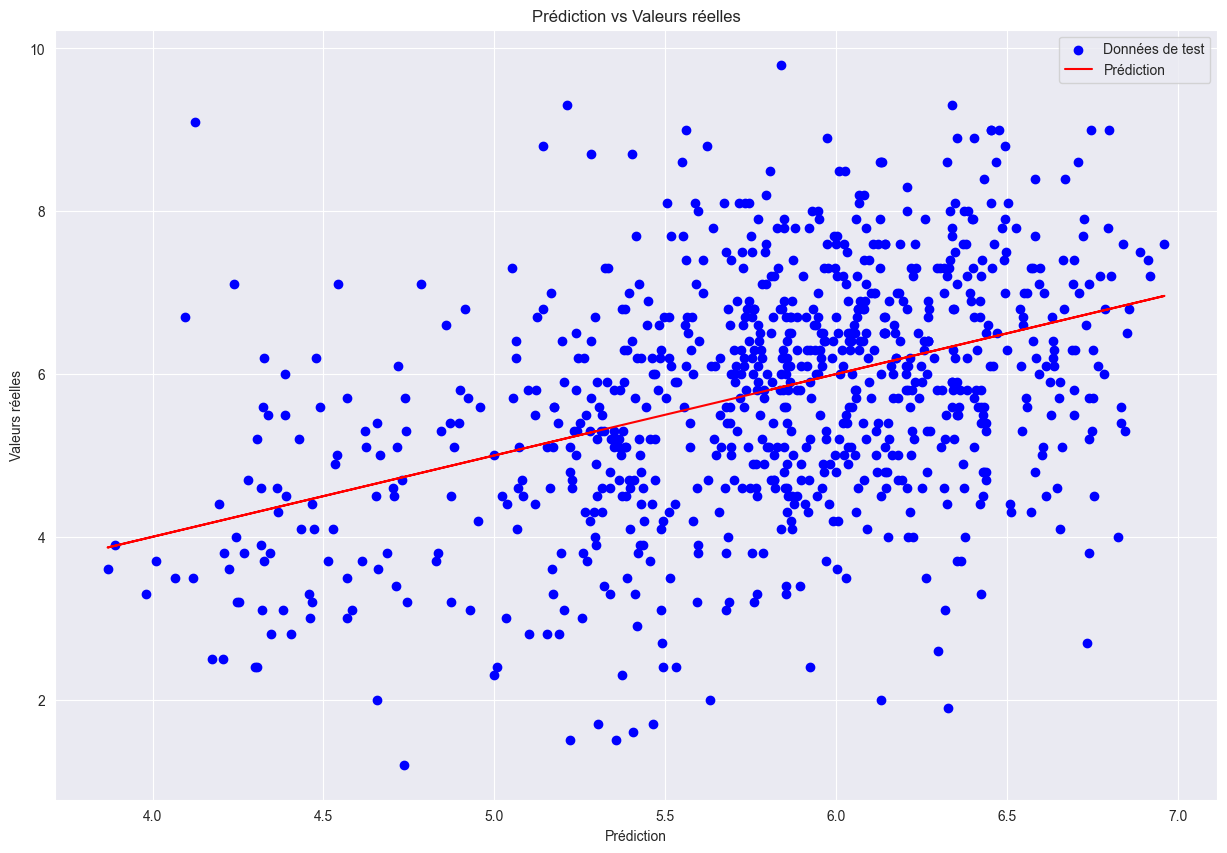

In [195]:
residuals = y_test - y_pred


plt.scatter(y_pred, residuals)
plt.title('Résidus vs Valeurs prédites')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

sns.histplot(residuals, kde=True)
plt.title('Distribution des Résidus')
plt.xlabel('Résidus')
plt.show()

plt.figure(figsize=(15, 10))
plt.scatter(y_pred, y_test, color='blue', label='Données de test')
plt.plot(y_pred, y_pred, color='red', label='Prédiction')
plt.title('Prédiction vs Valeurs réelles')
plt.xlabel('Prédiction')
plt.ylabel('Valeurs réelles')
plt.legend()
plt.show()

### 2.6 . Refaire la question précédente après avoir effectué une normalisation adéquate. Comparer les résultats.

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

X = df[['nbre_utilisateur_note_log', 'duree_log', 'Drama', 'Action', 'Thriller', 'Horror']]

y = df['utilisateur_note']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#R2
print('R2 :', r2_score(y_test, y_pred))

#MSE
print('MSE :', mean_squared_error(y_test, y_pred))

# r2adj
print('r2adj :', 1 - (1 - r2_score(y_test, y_pred)) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1)))

R2 : 0.171640144939877
MSE : 1.8296766456528166
r2adj : 0.16573032433302715


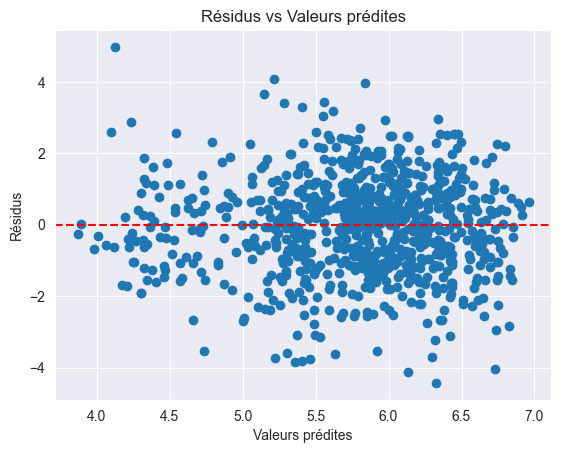

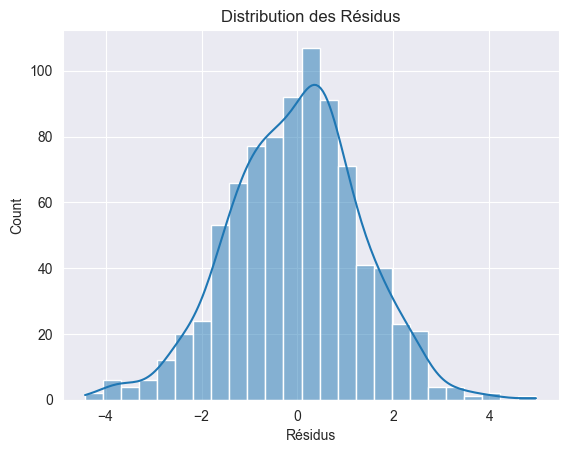

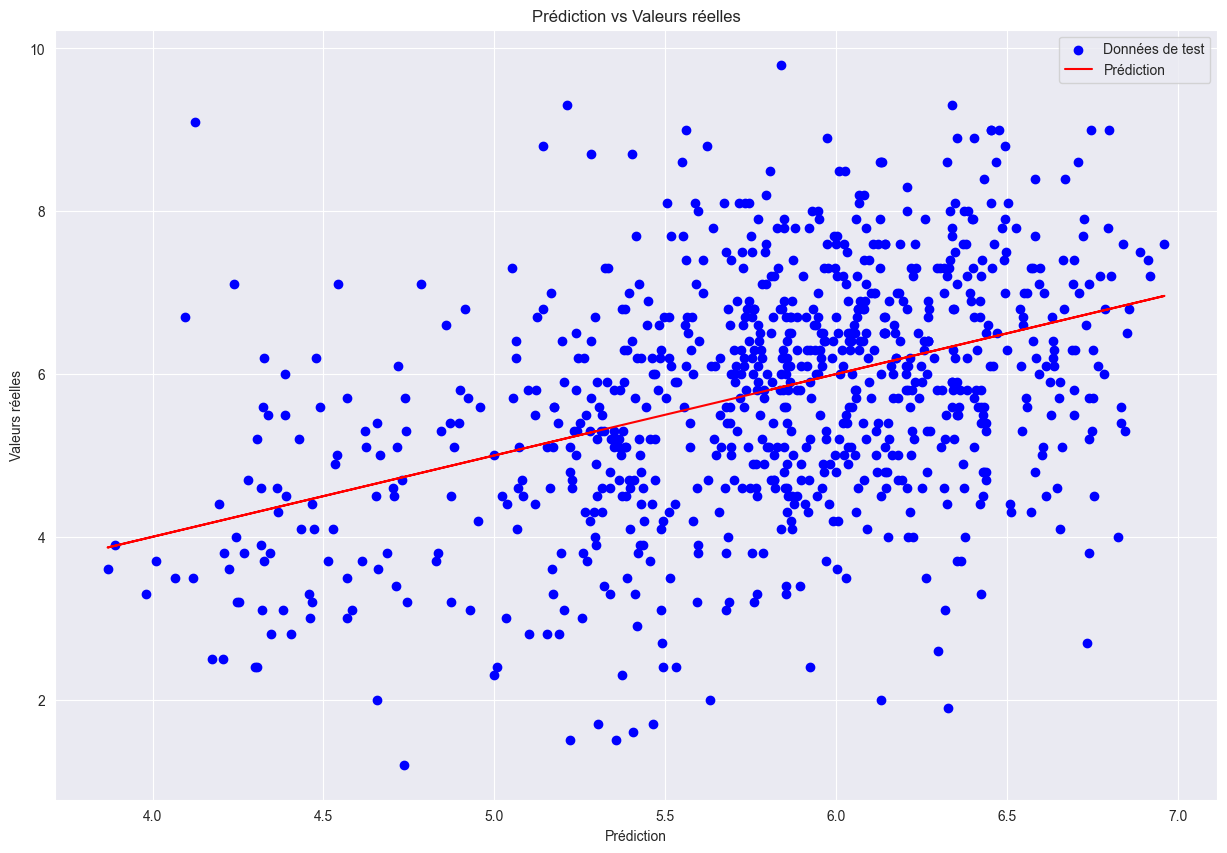

In [203]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.title('Résidus vs Valeurs prédites')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

sns.histplot(residuals, kde=True)
plt.title('Distribution des Résidus')
plt.xlabel('Résidus')
plt.show()

plt.figure(figsize=(15, 10))
plt.scatter(y_pred, y_test, color='blue', label='Données de test')
plt.plot(y_pred, y_pred, color='red', label='Prédiction')
plt.title('Prédiction vs Valeurs réelles')
plt.xlabel('Prédiction')
plt.ylabel('Valeurs réelles')
plt.legend()
plt.show()